# Mask Detection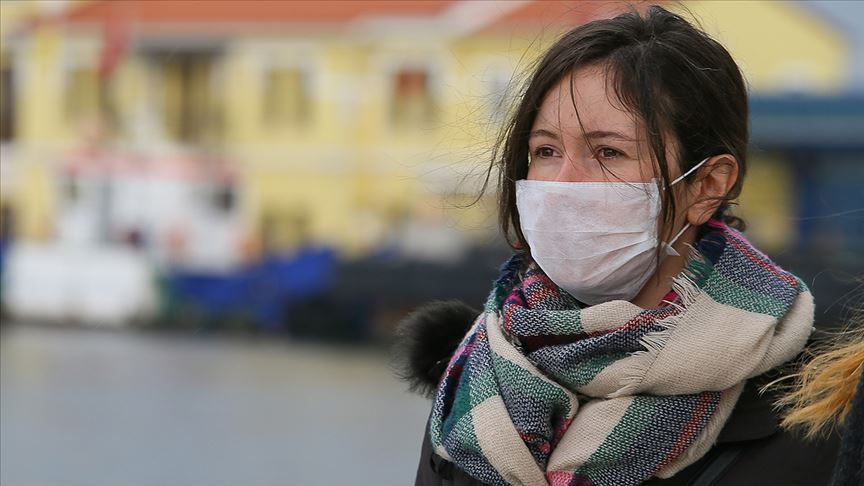

# Gerekli Kütüphanelerin Çağırılması
 ## İnserting of Libraries

In [1]:
# Data Manipulation
import pandas as pd

# Numerical Analysis
import numpy as np

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Operating System
import os

# Deep Learning and Object Detection
import tensorflow as tf
import keras
import cv2

# Data Extraction
import glob
from xml.etree import ElementTree


In [2]:
print('Tensorflow Version: {}'.format(tf.__version__))
print('Keras Version: {}'.format(keras.__version__))

Tensorflow Version: 2.17.0
Keras Version: 3.4.1


## Extraction dataset from Google Drive

In [3]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/archive.zip", "r") as zipObj:
    zipObj.extractall("/content/data")


In [4]:
input_data_path = '/content/data/images'
annotations_path = "/content/data/annotations"
images = [*os.listdir("/content/data/images")]
output_data_path =  '.'


## Read The annotations

In [5]:
import xml.etree.ElementTree as ET # is used to parse an XML (inherently hierarchical) data format, which is the format of the annotations file

def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result


def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)

    return params

def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [6]:
import glob
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]

# Since the output of the parse_annotation function is a list of lists, we need to flatten the ctopped faces.
# i.e make it a list of images instead of a list of lists.
full_dataset = sum(dataset, []) #
#full_dataset

df = pd.DataFrame(full_dataset)
df.shape


(4072, 9)

In [7]:
df.head()


,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss199,400,276,3,with_mask,44,143,53,156
1,maksssksksss199,400,276,3,mask_weared_incorrect,134,118,143,128
2,maksssksksss199,400,276,3,with_mask,210,101,220,116
3,maksssksksss199,400,276,3,with_mask,271,127,281,140
4,maksssksksss199,400,276,3,with_mask,320,113,333,127


Omit one image from the dataset in order to use it at the end of the project for illustrating the results of the model

In [8]:
final_test_image = 'maksssksksss0' # chose the image
df_final_test = df.loc[df["file"] == final_test_image] # create a separate dataframe which contain only the people in this specific image
images.remove(f'{final_test_image}.png') # remove the image from the full dataset
df = df.loc[df["file"] != final_test_image] # remove the information of the image from the full dataset


In [9]:
df_final_test.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
567,maksssksksss0,512,366,3,without_mask,79,105,109,142
568,maksssksksss0,512,366,3,with_mask,185,100,226,144
569,maksssksksss0,512,366,3,without_mask,325,90,360,141


Rename some columns

In [10]:
df.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)
df_final_test.rename(columns = {'file':'file_name', 'name':'label'}, inplace = True)

## Prepare the data

In [11]:
labels = df['label'].unique()
directory = ['train', 'test', 'val']
output_data_path =  '.'

import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        #print(path)
        if not os.path.exists(path):
            os.makedirs(path)

In [12]:
from PIL import Image
def crop_img(image_path, x_min, y_min, x_max, y_max):

    '''
     This function takes an image path + x and y coordinates of two opposite corners of the rectangle
     and returns a cropped image
    '''
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

In [13]:
def extract_faces(image_name, image_info):

    '''
     This function takes an image name + dataframe with information about the image
     and splits the image into all the different faces. image name contains the
     upper-left coordinate of each face so we could distinguish it later
    '''
    faces = []
    df_one_img = image_info[image_info['file_name'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'label']]
    #print(df_one_img)
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num]
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [14]:
cropped_faces = [extract_faces(img, df) for img in images]

In [15]:
#flat_cropped_faces = [item for sublist in cropped_faces for item in sublist]
flat_cropped_faces = sum(cropped_faces, [])
#flat_cropped_faces

In [16]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

In [17]:
print(f'num of images with mask: {len(with_mask)}')
print(f'num of images without mask: {len(without_mask)}')
print(f'num of images incorrect mask: {len(mask_weared_incorrect)}')
print(f'sum: {len(with_mask) + len(without_mask) + len(mask_weared_incorrect) }')

num of images with mask: 3231
num of images without mask: 715
num of images incorrect mask: 123
sum: 4069


In [18]:
from sklearn.model_selection import train_test_split

train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)

train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [19]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    '''
     This function takes an image name + a path of output folder
     and saves image into the output folder
    '''

    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)

In [20]:
# Train set


for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')

# Test set

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')

# Val set

for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')


# Model Building - CNN


In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3,3),  padding='same', activation = 'relu', input_shape = (35,35,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = (3,3),  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 35, 35, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 17, 17, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 17, 17, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │         512,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,503 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 537,587 (2.05 MB)

 Trainable params: 537,587 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),"acc"])

In [23]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, verbose=1, mode="min"),
    ModelCheckpoint(filepath="mymodel.keras", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)
]


In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 8
epochs = 50

# Training data augmentation and rescaling
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    zoom_range=0.1,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=4,
    vertical_flip=False
)

# Validation and test data rescaling
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Training data generator
train_generator = datagen.flow_from_directory(
    directory='/content/train',
    target_size=(35, 35),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

# Validation data generator
val_generator = val_datagen.flow_from_directory(
    directory='/content/val',
    target_size=(35, 35),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

# Test data generator
test_generator = val_datagen.flow_from_directory(
    directory='/content/test',
    target_size=(35, 35),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)


Found 3254 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [27]:
history = model.fit(
    x=train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=callbacks
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


406/407 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 0.8460 - loss: 0.4545 - precision: 0.8626 - recall: 0.8224
Epoch 1: val_loss improved from inf to 0.23395, saving model to mymodel.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - acc: 0.8462 - loss: 0.4540 - precision: 0.8628 - recall: 0.8226 - val_acc: 0.9300 - val_loss: 0.2340 - val_precision: 0.9456 - val_recall: 0.9300
Epoch 2/50
405/407 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.9272 - loss: 0.2409 - precision: 0.9302 - recall: 0.9203
Epoch 2: val_loss did not improve from 0.23395
407/407 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - acc: 0.9272 - loss: 0.2409 - precision: 0.9302 - recall: 0.9202 - val_acc: 0.9053 - val_loss: 0.2368 - val_precision: 0.9244 - val_recall: 0.9053
Epoch 3/50
406/407 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.9166 - loss: 0.2444 - precision: 0.9231 - recall: 0.9077
Epoch 3: val_loss improved from 0.23395 to 0.19900, saving model to mymodel.keras
407/407 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - acc: 0.9166 - loss: 

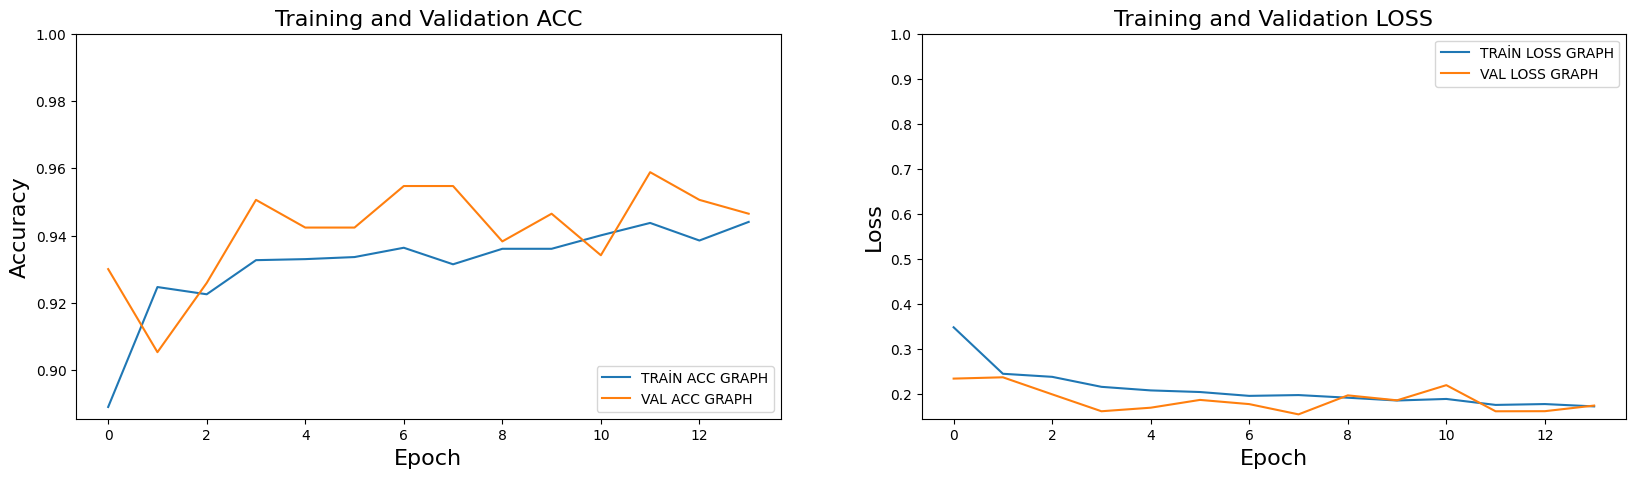

In [30]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history["acc"],label="TRAİN ACC GRAPH")
plt.plot(history.history["val_acc"],label="VAL ACC GRAPH")
plt.legend(loc="lower right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validation ACC",fontsize=16)



plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="TRAİN LOSS GRAPH")
plt.plot(history.history["val_loss"],label="VAL LOSS GRAPH")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validation LOSS",fontsize=16)
plt.show()

In [31]:
loss,precision,recall,acc = model.evaluate(test_generator,batch_size=32)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - acc: 0.8858 - loss: 0.3949 - precision: 0.8858 - recall: 0.8858


In [32]:
# Sonuçları yüzdelik olarak hesaplayıp yazdırma
print(f"Loss: {loss * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Accuracy: {acc * 100:.2f}%")

Loss: 17.40%
Precision: 94.65%
Recall: 94.65%
Accuracy: 94.65%


In [38]:
import cv2
img = cv2.imread(os.path.join(input_data_path, f'{final_test_image}.png'))
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)


mask_label = {0:'MASK INCORRECT',1:'MASK', 2:'NO MASK'}
color_label = {0:(0,255,255),1:(0, 255,0), 2:(255,0,0)}
cropped_faces = extract_faces(f'{final_test_image}.png', df_final_test)

df_test_img = df_final_test[['xmin', 'ymin', 'xmax', 'ymax', 'label']]

In [39]:
df_test_img

,xmin,ymin,xmax,ymax,label
567,79,105,109,142,without_mask
568,185,100,226,144,with_mask
569,325,90,360,141,without_mask


In [41]:
cropped_faces

[(<PIL.Image.Image image mode=RGB size=36x45>,
  'without_mask',
  'maksssksksss0_(79, 105)'),
 (<PIL.Image.Image image mode=RGB size=49x52>,
  'with_mask',
  'maksssksksss0_(185, 100)'),
 (<PIL.Image.Image image mode=RGB size=42x61>,
  'without_mask',
  'maksssksksss0_(325, 90)')]

## TEST

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


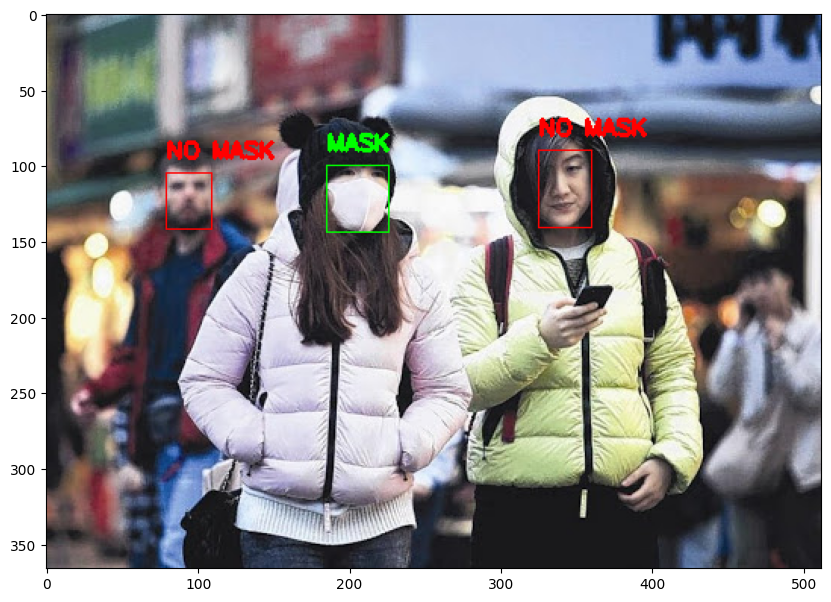

In [50]:
for idx, face in enumerate(cropped_faces):

    x_min, y_min, x_max, y_max, label = df_test_img.iloc[idx]

    resized_face = cv2.resize(np.array(face[0]),(35,35))
    reshaped_face = np.reshape(resized_face,[1,35,35,3])/255.0

    face_result = model.predict(reshaped_face)
    cv2.putText(colored_img,mask_label[face_result.argmax()],(x_min, y_min-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,color_label[face_result.argmax()],2)
    cv2.rectangle(colored_img,(x_min, y_min), (x_max, y_max), color_label[face_result.argmax()]) # print a blue rectangle of each person's face using the given coordinates

plt.figure(figsize=(10, 10))
plt.imshow(colored_img)